## Argoverse Stereo Tutorial
Similar to KITTI, Argoverse provides synchronized stereo images, LiDAR, and 3d object annotations. However, Argoverse's imagery is fully panoramic and includes far more annotations than KITTI. We provide an example here of how to rectify the stereo images and use them for stereo depth estimation. Thanks to [Xiangyu Chen](https://github.com/argoai/argoverse-api/issues/82) for suggesting this code.

We'll use a scene from Pittsburgh, PA:

In [69]:
import imageio
from argoverse.data_loading.simple_track_dataloader import SimpleArgoverseTrackingDataLoader

val_dir = '/Users/johnlamb/Downloads/ARGOVERSE-COMPETITION/val/argoverse-tracking/val'
# log_id = '1d676737-4110-3f7e-bec0-0c90f74c248f'
# lidar_timestamp = 315984808920125000 # in nanosec.

log_id = '64724064-6472-6472-6472-764725145600'
lidar_timestamp = 315966844418603000 # in nanosec.

# get corresponding left and right stereo timestamps
dl = SimpleArgoverseTrackingDataLoader(data_dir=val_dir, labels_dir=val_dir)
left_fpath = dl.get_closest_im_fpath(log_id, 'stereo_front_left', lidar_timestamp)
right_fpath = dl.get_closest_im_fpath(log_id, 'stereo_front_right', lidar_timestamp)
# load the images
left_img = imageio.imread(left_fpath)
right_img = imageio.imread(right_fpath)

We'll plot the horizontal scanlines before and after rectification. Before rectification:

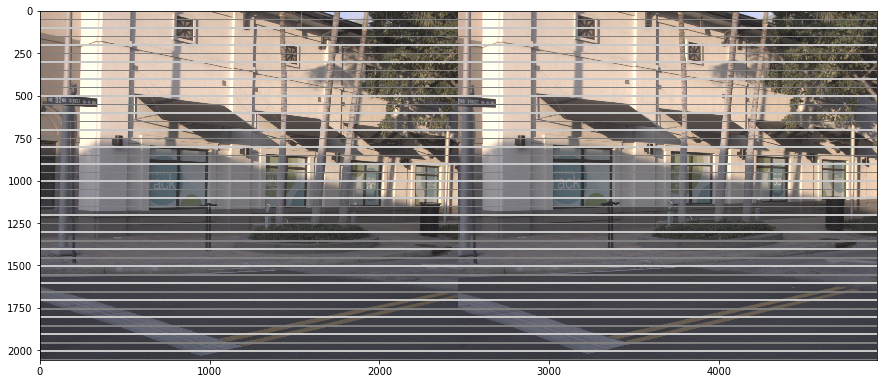

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from argoverse.utils.camera_stats import STEREO_IMG_WIDTH, STEREO_IMG_HEIGHT

SHOW_EVERY = 100 # every 100 px, show line
LINE_WIDTH = 10
def vis_pair(left_img, right_img):
    pair_img = np.zeros((STEREO_IMG_HEIGHT,STEREO_IMG_WIDTH*2,3), dtype=np.uint8)
    pair_img[:,:STEREO_IMG_WIDTH,:] = left_img
    pair_img[:,STEREO_IMG_WIDTH:,:] = right_img
    for i in range(0,STEREO_IMG_HEIGHT, SHOW_EVERY):
        pair_img[i:i+LINE_WIDTH,:,:] = np.ones(3)*200 # white lines
    for i in range(50,STEREO_IMG_HEIGHT, SHOW_EVERY):
        pair_img[i:i+LINE_WIDTH,:,:] = np.ones(3)*128 # gray
    fig = plt.figure(figsize=(15,8))
    plt.imshow(pair_img)
    plt.show()
vis_pair(left_img, right_img)

We provide a SE(3) [transformation in argoverse-api](https://github.com/argoai/argoverse-api/blob/2f93a9e18321ec6199c3f6345c533581678382b7/argoverse/utils/calibration.py#L263) from the egovehicle frame (w/ origin at center of back axle) to the camera coordinate frame as follows:
$$ {}^{camL}T_{egovehicle} = \begin{bmatrix} R_L & t_L \\ 0 & 1 \end{bmatrix}$$
$$ {}^{camR}T_{egovehicle} = \begin{bmatrix} R_R & t_R \\ 0 & 1 \end{bmatrix}$$
Since `cv2.stereoRectify()` expects a Left -> Right transformation matrix, we can compute it as:
$$ {}^{camR}T_{camL} = {}^{camR}T_{egovehicle} {}^{egovehicle}T_{camL}  $$
$$ {}^{camR}T_{camL} = \begin{bmatrix} R_R & t_R \\ 0 & 1 \end{bmatrix} \begin{bmatrix} R_L^T & -R_L^Tt_L \\ 0 & 1 \end{bmatrix}  $$



In [60]:
import numpy as np
import cv2
# TODO: fix RGB to BGR in OpenCV calls
def rectify_image(calibL, calibR, left_img, right_img):
    #left_img, right_img = cv2.imread(left_src), cv2.imread(right_src)
    #calibL, calibR = copy.deepcopy(calibL), copy.deepcopy(calibR)
    camR_T_camL = np.dot(calibR.extrinsic, np.linalg.inv(calibL.extrinsic))
    # takes us from left -> right
    camR_R_camL = camR_T_camL[:3, :3]
    camR_t_camL = camR_T_camL[:3, 3]

    distCoeff = np.zeros(4)
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        cameraMatrix1=calibL.intrinsic[:3, :3],
        distCoeffs1=distCoeff,
        cameraMatrix2=calibR.intrinsic[:3, :3],
        distCoeffs2=distCoeff,
        imageSize=(STEREO_IMG_WIDTH, STEREO_IMG_HEIGHT),
        R=camR_R_camL,
        T=camR_t_camL,
        flags=cv2.CALIB_ZERO_DISPARITY,
        alpha=0
    )
    # computes the joint undistortion and rectification transformation, but
    # but pass zero values to ignore undistortion
    map1x, map1y = cv2.initUndistortRectifyMap(
        cameraMatrix=calibL.intrinsic[:3, :3],
        distCoeffs=distCoeff,
        R=R1,
        newCameraMatrix=P1,
        size=(STEREO_IMG_WIDTH, STEREO_IMG_HEIGHT),
        m1type=cv2.CV_32FC1)

    map2x, map2y = cv2.initUndistortRectifyMap(
        cameraMatrix=calibR.intrinsic[:3, :3],
        distCoeffs=distCoeff,
        R=R2,
        newCameraMatrix=P2,
        size=(STEREO_IMG_WIDTH, STEREO_IMG_HEIGHT),
        m1type=cv2.CV_32FC1)

    left_img_rect = cv2.remap(left_img, map1x, map1y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    right_img_rect = cv2.remap(right_img, map2x, map2y, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
    return left_img_rect, right_img_rect

We now rectify the images and plot the horizontal scanlines, which are now epipolar lines:

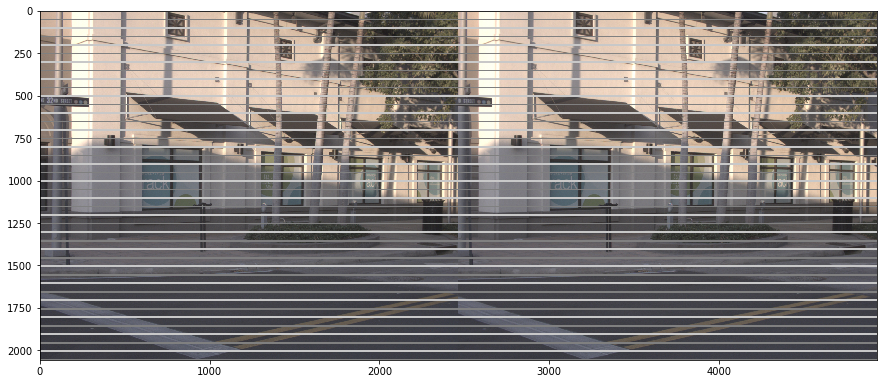

In [68]:
# Load the calibration data for stereo cameras of this log
from argoverse.utils.calibration import get_calibration_config

log_calib_data = dl.get_log_calibration_data(log_id)
calibL = get_calibration_config(log_calib_data, camera_name='stereo_front_left')
calibR = get_calibration_config(log_calib_data, camera_name='stereo_front_right')

left_img_rect, right_img_rect = rectify_image(calibL, calibR, left_img, right_img)
vis_pair(left_img_rect, right_img_rect)

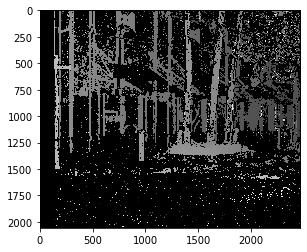

In [65]:
# Convert to grayscale
left_img_rect_gray = cv2.cvtColor(left_img_rect, cv2.COLOR_BGR2GRAY)
right_img_rect_gray = cv2.cvtColor(right_img_rect, cv2.COLOR_BGR2GRAY)

# Block Matching
stereo = cv2.StereoBM_create(numDisparities=128, blockSize=15)
disparity = stereo.compute(left_img_rect_gray,right_img_rect_gray)

# _, disparity = cv2.threshold(disparity,0, max_disparity * 16, cv2.THRESH_TOZERO)
# disparity_scaled = (disparity / 16.).astype(np.uint8)

plt.imshow(disparity,'gray')
plt.show()


Computing the disparity  map...


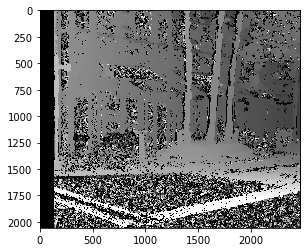

In [67]:
min_disp = 1
max_disparity = 128
num_disp = 128
win_size=5
#Create Block matching object. 
# stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
#  numDisparities = num_disp,
#  blockSize = 5,
#  uniquenessRatio = 5,
#  speckleWindowSize = 5,
#  speckleRange = 5,
#  disp12MaxDiff = 1,
#  P1 = 8*3*win_size**2,#8*3*win_size**2,
#  P2 =32*3*win_size**2) #32*3*win_size**2)

stereo = cv2.StereoSGBM_create(0, max_disparity, 21)

#Compute disparity map
print ("\nComputing the disparity  map...")
disparity = stereo.compute(left_img_rect_gray,right_img_rect_gray)

_, disparity = cv2.threshold(disparity,0, max_disparity * 16, cv2.THRESH_TOZERO)
disparity_scaled = (disparity / 16.).astype(np.uint8)

#Show disparity map before generating 3D cloud to verify that point cloud will be usable. 
plt.imshow(disparity,'gray')
plt.show()

In [64]:
# Compare with pre-trained mono-depth
# Vladlen model